# **Introduction**

The San Francisco Controller's Office maintains a database of the salary and benefits
paid to City employees between fiscal years 2013 - 2017.

The dataset hosted by the city of San Francisco. The organization has an open data
platform and they update their information according the amount of data that is brought
in.

This dataset is updated annually. New data is added on a bi-annual basis when available
for each fiscal and calendar year.

The dataset is in csv file: "employee-compensation.csv"

Our target is to predict the salary.

The csv file includes 213K observations and 22 features. After cleaning the Nan's and
defining the interested population as employees with total annual salary of at least
35,000$, we have almost 150K observations.

Three models were selected - Linear Regression, Decision Tree Regressor and Random Forest Regressor.

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from time import time

['socrata_metadata.json', 'CON_DataDictionary_Employee-Compensation.xlsx', 'CON_DataDictionary_Employee-Compensation.pdf', 'employee-compensation.csv']


# **Data Preparation**
## **Load Data**

In [2]:
df = pd.read_csv('employee-compensation.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213202 entries, 0 to 213201
Data columns (total 22 columns):
Year Type                  213202 non-null object
Year                       213202 non-null int64
Organization Group Code    213202 non-null int64
Organization Group         213202 non-null object
Department Code            213202 non-null object
Department                 213202 non-null object
Union Code                 212987 non-null float64
Union                      212987 non-null object
Job Family Code            212982 non-null object
Job Family                 212982 non-null object
Job Code                   213202 non-null object
Job                        213202 non-null object
Employee Identifier        213202 non-null int64
Salaries                   213202 non-null float64
Overtime                   213202 non-null float64
Other Salaries             213202 non-null float64
Total Salary               213202 non-null float64
Retirement                 213202 non

In [4]:
df.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Fiscal,2013,1,Public Protection,FIR,FIR Fire Department,798.0,"Firefighters - Miscellaneous, Local 798",H000,Fire Services,H003,EMT/Paramedic/Firefighter,37216,123841.28,76853.77,14922.05,215617.10,24574.98,14920.13,3589.87,43084.98,258702.08
1,Fiscal,2014,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,261.0,"Laborers, Local 261",7500,Semi-Skilled & General Labor,7514,General Laborer,24950,61137.60,7341.04,9218.74,77697.38,14897.71,12516.70,6117.99,33532.40,111229.78
2,Fiscal,2016,2,"Public Works, Transportation & Commerce",AIR,AIR Airport Commission,790.0,"SEIU - Miscellaneous, Local 1021",1400,"Clerical, Secretarial & Steno",1406,Senior Clerk,27447,41192.82,0.00,390.00,41582.82,6996.41,11308.96,3200.69,21506.06,63088.88
3,Fiscal,2015,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,253.0,"Transport Workers - Transit Operators, Local 2...",9100,Street Transit,9163,Transit Operator,42001,66993.68,26633.83,4494.98,98122.49,21231.91,13417.45,7449.63,42098.99,140221.48
4,Fiscal,2013,2,"Public Works, Transportation & Commerce",DPW,DPW GSA - Public Works,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",5200,Professional Engineering,5201,Junior Engineer,22142,74260.80,0.00,0.00,74260.80,13522.95,11989.39,5977.19,31489.53,105750.33


## **Check for missing values (NaN)**

In [5]:
#Checking for nulls
print(df.isnull().sum())
df[df.Union.isnull() == True].head()

Year Type                    0
Year                         0
Organization Group Code      0
Organization Group           0
Department Code              0
Department                   0
Union Code                 215
Union                      215
Job Family Code            220
Job Family                 220
Job Code                     0
Job                          0
Employee Identifier          0
Salaries                     0
Overtime                     0
Other Salaries               0
Total Salary                 0
Retirement                   0
Health/Dental                0
Other Benefits               0
Total Benefits               0
Total Compensation           0
dtype: int64


,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
2772,Fiscal,2017,5,Culture & Recreation,REC,REC Recreation & Park Commsn,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,18828,13569.05,0.00,370.42,13939.47,0.00,5409.33,1081.93,6491.26,20430.73
4484,Fiscal,2017,4,Community Health,DPH,DPH Public Health,NaN,NaN,NaN,NaN,1010,Information Systems Trainee,46555,25821.40,0.00,0.00,25821.40,4707.26,6381.72,2060.13,13149.11,38970.51
4687,Fiscal,2016,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,NaN,NaN,NaN,NaN,9152,Transportation Controller Trainee,8869,17626.21,834.82,1349.21,19810.24,3536.07,2464.33,1561.30,7561.70,27371.94
4732,Fiscal,2017,5,Culture & Recreation,REC,REC Recreation & Park Commsn,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,25231,6929.23,0.00,201.08,7130.31,0.00,2762.33,553.43,3315.76,10446.07
5193,Fiscal,2017,5,Culture & Recreation,REC,REC Recreation & Park Commsn,NaN,NaN,NaN,NaN,3278,Recreation Facility Assistant,33565,14958.18,0.00,628.42,15586.60,0.00,5963.08,1209.77,7172.85,22759.45


In [6]:
#Checking what are the jobs that have nulls
df[df.Union.isnull() == True]['Organization Group'].value_counts()
df[df.Union.isnull() == True][df['Organization Group'] == 'Community Health'].Job.value_counts()
df[df.Job == 'Technology Expert II'].shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(3, 22)

# **Exploratory Visualization**
## **Heatmap**

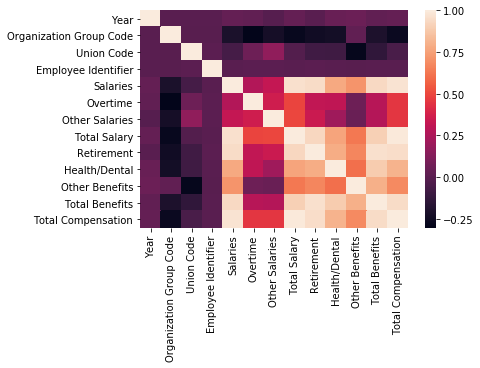

In [7]:
sns.heatmap(df.corr())

## **Scatter Matrix**

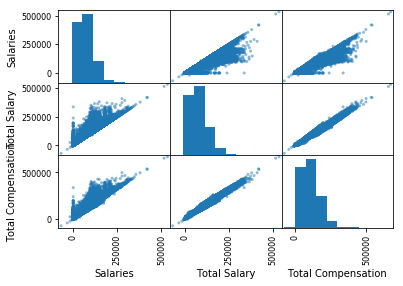

In [8]:
salaries_sm = scatter_matrix(df[['Salaries', 'Total Salary', 'Total Compensation']])
#['Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits', 'Total Compensation']

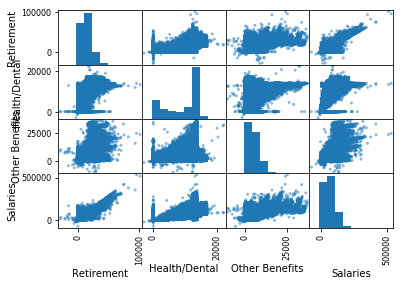

In [9]:
benefits_sm = scatter_matrix(df[['Retirement', 'Health/Dental', 'Other Benefits', 'Salaries']])

## **Target**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


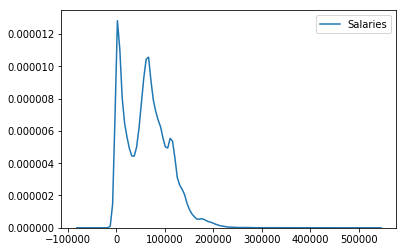

In [10]:
ax = sns.kdeplot(df['Salaries'])
ax#.set_xlim(20000,50000)

In [11]:
df['Salaries'].describe()

count    213202.000000
mean      63818.588137
std       45437.255368
min      -68771.780000
25%       23165.535000
50%       63210.840000
75%       93215.010000
max      533985.940000
Name: Salaries, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


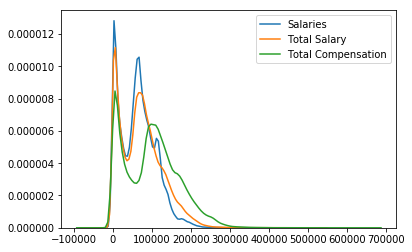

In [12]:
salary = ['Salaries', 'Total Salary', 'Total Compensation']

for col in salary:
    ax_salary = sns.kdeplot(df[col])
    ax_salary#.set_xlim(-25000,75000)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


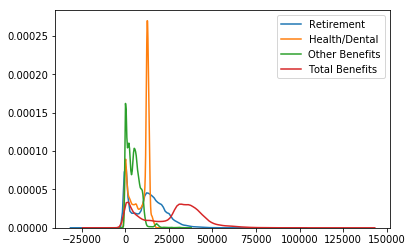

In [13]:
benefits = ['Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits'] 

for col in benefits:
    ax_benefits = sns.kdeplot(df[col])
    ax_benefits#.set_xlim(-25000,75000)

## **Sample the data** 
### by removing salaries lower than 35,000 $

In [14]:
# Removing Salaries lower than 35000 
df[df['Salaries'] < 35000].count()
#ax.set_xlim(20000,50000)
#df['Job'][df.Salaries < 0].value_counts()

Year Type                  65232
Year                       65232
Organization Group Code    65232
Organization Group         65232
Department Code            65232
Department                 65232
Union Code                 65044
Union                      65044
Job Family Code            65044
Job Family                 65044
Job Code                   65232
Job                        65232
Employee Identifier        65232
Salaries                   65232
Overtime                   65232
Other Salaries             65232
Total Salary               65232
Retirement                 65232
Health/Dental              65232
Other Benefits             65232
Total Benefits             65232
Total Compensation         65232
dtype: int64

In [15]:
df2 = df[df['Salaries'] > 35000]

In [16]:
# What and how many organizations we are losing by reducing the data to salaries < 35,000$
org_x = df[df.Salaries<35000]['Organization Group'].value_counts()
org_y = df['Organization Group'].value_counts()
org_z = pd.concat([org_x, (org_x/org_y)], axis=1, join='inner', sort=False)
org_z.columns = ['Organization Count', 'Organization %']
org_z

,Organization Count,Organization %
"Public Works, Transportation & Commerce",17066,0.253622
Community Health,13552,0.293836
Culture & Recreation,12220,0.619110
Human Welfare & Neighborhood Development,8911,0.454782
Public Protection,6655,0.163297
General Administration & Finance,6577,0.338323
General City Responsibilities,251,0.943609


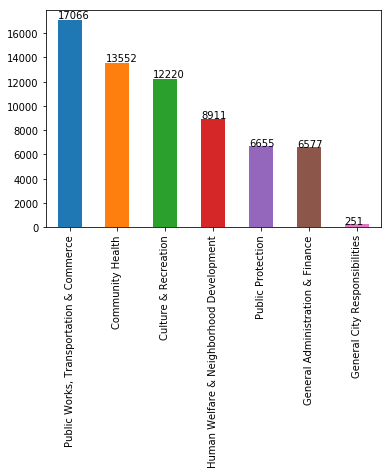

In [17]:
org_ax = org_z['Organization Count'].plot('bar')
for p in org_ax.patches:
    org_ax.annotate(int(p.get_height()), (p.get_x(), p.get_height() * 1.01))

In [18]:
# What and how many departments we are losing by reducing the data to salaries < 35,000$
dep_x = df[df.Salaries<35000].Department.value_counts()
dep_y = df.Department.value_counts()
dep_z = pd.concat([dep_x, (dep_x/dep_y)], axis=1, join='inner', sort=False)
dep_z.columns = ['Department Count', 'Department %']
dep_z.head(10)

,Department Count,Department %
DPH Public Health,13552,0.293836
REC Recreation & Park Commsn,8805,0.710941
HSA Human Services Agency,8107,0.467128
MTA Municipal Transprtn Agncy,7482,0.240896
POL Police,2889,0.170222
DPW GSA - Public Works,2594,0.314539
AIR Airport Commission,2461,0.247014
LIB Public Library,2118,0.437603
ADM Gen Svcs Agency-City Admin,1771,0.329243
PUB Public Utilities Bureaus,1494,0.307724


In [19]:
# What and how many jobs we are losing by reducing the data to salaries < 35,000$
job_x = df[df.Salaries<35000].Job.value_counts()
job_y = df.Job.value_counts()
job_z = pd.concat([job_x, (job_x/job_y)], axis=1, join='inner', sort=False)
job_z.columns = ['Job Count', 'Job %']
job_z.head(10)

,Job Count,Job %
Special Nurse,5042,0.657967
Public Svc Aide-Public Works,4166,0.998801
Public Service Trainee,4038,0.956645
Recreation Leader,3669,0.996469
Transit Operator,3148,0.240507
Library Page,1291,0.909155
Junior Clerk,1143,0.932300
"Stdntdsgntrain1, Arch/Eng/Plng",1110,0.951973
Police Officer,1002,0.264101
Publ Svc Aide-Asst To Prof,1001,0.952426


## ** Continuing with Exploratory Visualization**
### ** Distribution of salaries by organizations **

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


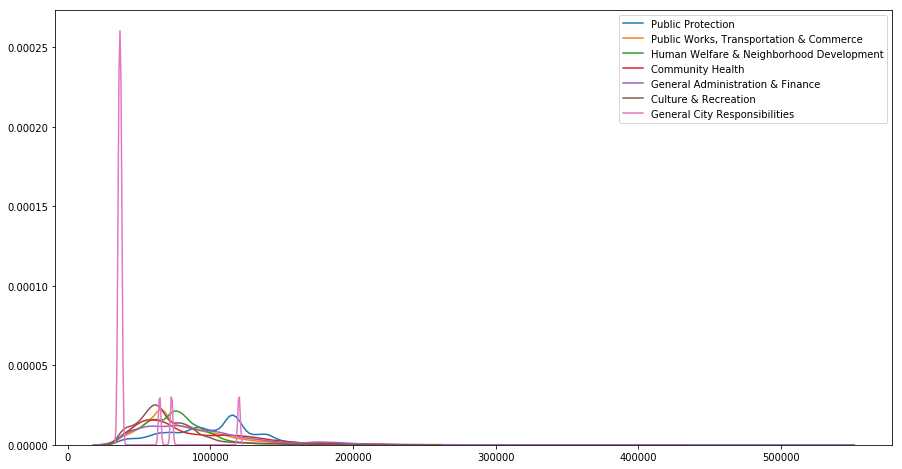

In [20]:
plt.figure(figsize=(15,8))
for col in list(df2['Organization Group'].unique()):
    ax = sns.kdeplot(df2['Salaries'][df2['Organization Group'] == col], label = col)
#ax.set_ylim(0,0.0001)

### ** Distribution of salaries by years **

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


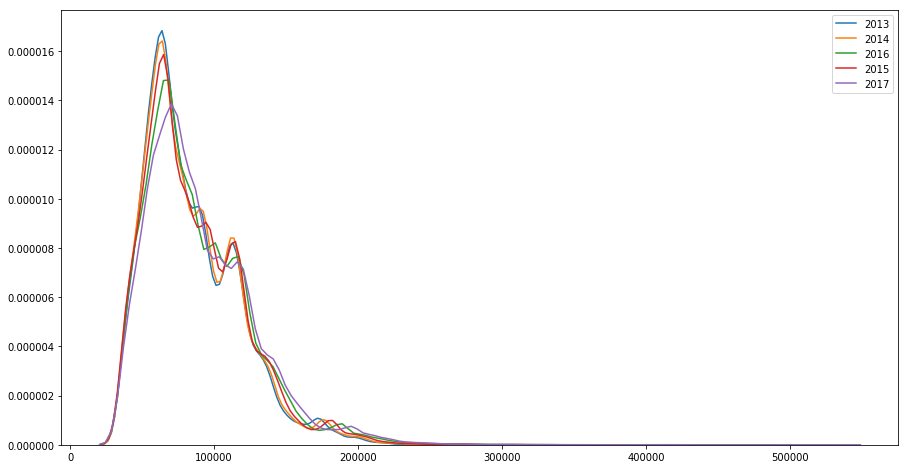

In [21]:
plt.figure(figsize=(15,8))
for col in list(df2['Year'].unique()):
    sns.kdeplot(df2['Salaries'][df2['Year'] == col], label = col)

### ** Distribution of overtime by organizations **

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


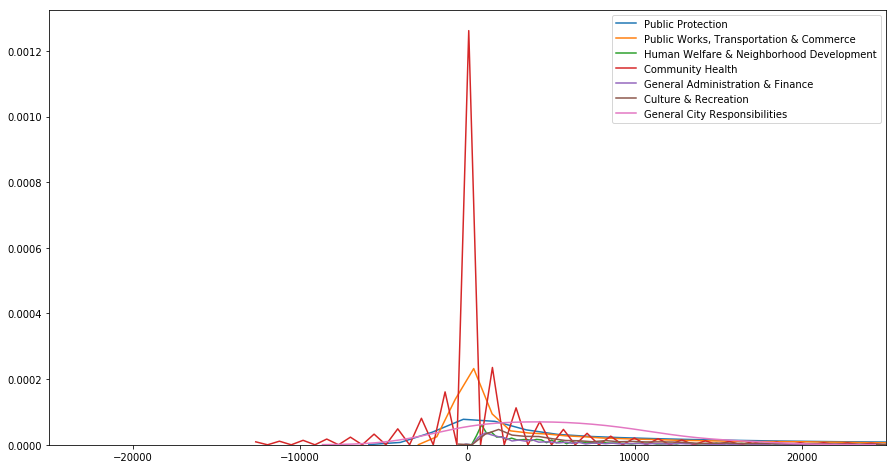

In [22]:
plt.figure(figsize=(15,8))
for col in list(df2['Organization Group'].unique()):
    sns.kdeplot(df2['Overtime'][df2['Organization Group'] == col], label = col).set_xlim(-25000,25000)

### ** Most compensating jobs **

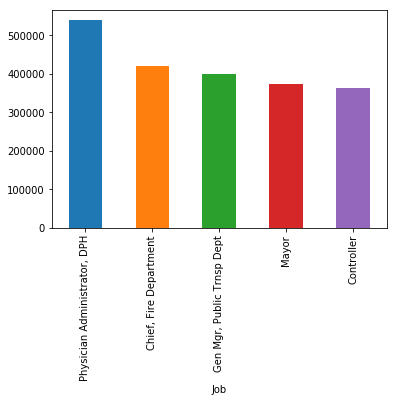

In [23]:
df_groupby_Job = df.groupby('Job').mean()
df_groupby_Job['Total Compensation'].sort_values(ascending = False).head(5).plot('bar')

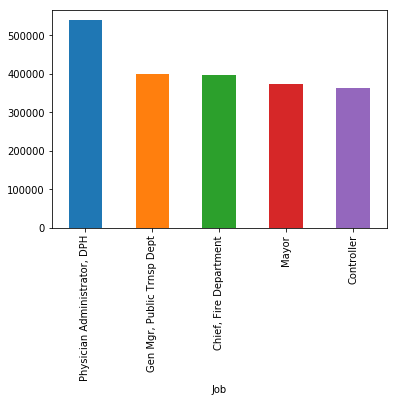

In [24]:
df_groupby_Job['Total Compensation No Extras'] = df_groupby_Job['Total Compensation'] - df_groupby_Job['Overtime'] - df_groupby_Job['Other Salaries']
df_groupby_Job['Total Compensation No Extras'].sort_values(ascending = False).head(5).plot('bar')

# ** Preprocessing **
### ** Replacing sequential features to categorial features **

In [25]:
df2['Overtime Amount'] = pd.Series(df2.Overtime / df2.Salaries)
#df2['Overtime Amount'].sort_values(ascending = False)#.hist()

df2['Overtime Amount'] = pd.cut(df2['Overtime Amount'], 5, labels = ['few overtime', 'less than average overtime', 'average overtime',
                                                                     'more than average overtime', 'many overtime'])
#df2['Overtime Amount']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [26]:
df2['Retirement Amount'] = pd.Series(df2.Retirement / df2.Salaries)
#df2['Retirement Amount'].sort_values(ascending = False)#.hist()

df2['Retirement Amount'] = pd.cut(df2['Retirement Amount'], 5, labels = ['few retirement', 'less than average retirement', 'average retirement',
                                                                     'more than average retirement', 'many retirement'])
#df2['Retirement Amount']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [27]:
df2['Health/Dental Amount'] = pd.Series(df2['Health/Dental'] / df2.Salaries)
#df2['Health/Dental Amount'].sort_values(ascending = False)#.hist()

df2['Health/Dental Amount'] = pd.cut(df2['Health/Dental Amount'], 5, labels = ['few Health/Dental', 'less than average Health/Dental', 
                                                                               'average Health/Dental', 'more than average Health/Dental', 
                                                                               'many Health/Dental'])
#df2['Health/Dental Amount']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
df2['Other Benefits Amount'] = pd.Series(df2['Other Benefits'] / df2.Salaries)
#df2['Other Benefits Amount'].sort_values(ascending = False)#.hist()

df2['Other Benefits Amount'] = pd.cut(df2['Other Benefits Amount'], 5, labels = ['few Other Benefits', 'less than average Other Benefits', 
                                                                                 'average Other Benefits', 'more than average Other Benefits', 
                                                                                 'many Other Benefits'])
#df2['Other Benefits Amount']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
df2.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation,Overtime Amount,Retirement Amount,Health/Dental Amount,Other Benefits Amount
0,Fiscal,2013,1,Public Protection,FIR,FIR Fire Department,798.0,"Firefighters - Miscellaneous, Local 798",H000,Fire Services,H003,EMT/Paramedic/Firefighter,37216,123841.28,76853.77,14922.05,215617.10,24574.98,14920.13,3589.87,43084.98,258702.08,less than average overtime,average retirement,less than average Health/Dental,few Other Benefits
1,Fiscal,2014,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,261.0,"Laborers, Local 261",7500,Semi-Skilled & General Labor,7514,General Laborer,24950,61137.60,7341.04,9218.74,77697.38,14897.71,12516.70,6117.99,33532.40,111229.78,few overtime,more than average retirement,average Health/Dental,less than average Other Benefits
2,Fiscal,2016,2,"Public Works, Transportation & Commerce",AIR,AIR Airport Commission,790.0,"SEIU - Miscellaneous, Local 1021",1400,"Clerical, Secretarial & Steno",1406,Senior Clerk,27447,41192.82,0.00,390.00,41582.82,6996.41,11308.96,3200.69,21506.06,63088.88,few overtime,average retirement,more than average Health/Dental,less than average Other Benefits
3,Fiscal,2015,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,253.0,"Transport Workers - Transit Operators, Local 2...",9100,Street Transit,9163,Transit Operator,42001,66993.68,26633.83,4494.98,98122.49,21231.91,13417.45,7449.63,42098.99,140221.48,less than average overtime,more than average retirement,average Health/Dental,less than average Other Benefits
4,Fiscal,2013,2,"Public Works, Transportation & Commerce",DPW,DPW GSA - Public Works,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",5200,Professional Engineering,5201,Junior Engineer,22142,74260.80,0.00,0.00,74260.80,13522.95,11989.39,5977.19,31489.53,105750.33,few overtime,average retirement,average Health/Dental,less than average Other Benefits


## **Split features and targets from the data**

In [30]:
X = df2.drop(['Year Type', 'Organization Group', 'Department', 'Union', 'Job Family', 'Job', 'Employee Identifier', 'Salaries', 'Overtime', 
              'Other Salaries', 'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits', 'Total Compensation'
             ], axis = 1)
y = df2.Salaries
print(X.shape,
      y.shape)

(147970, 10) (147970,)


In [31]:
X.head()

,Year,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime Amount,Retirement Amount,Health/Dental Amount,Other Benefits Amount
0,2013,1,FIR,798.0,H000,H003,less than average overtime,average retirement,less than average Health/Dental,few Other Benefits
1,2014,2,MTA,261.0,7500,7514,few overtime,more than average retirement,average Health/Dental,less than average Other Benefits
2,2016,2,AIR,790.0,1400,1406,few overtime,average retirement,more than average Health/Dental,less than average Other Benefits
3,2015,2,MTA,253.0,9100,9163,less than average overtime,more than average retirement,average Health/Dental,less than average Other Benefits
4,2013,2,DPW,21.0,5200,5201,few overtime,average retirement,average Health/Dental,less than average Other Benefits


# **Training/Predicting Pipeline**

In [32]:
#Set a pipeline for filling the nulls
def get_Job_Family_Code(df):
    return df[['Job Family Code']]

FullTransformerJobFamilyCode  = Pipeline([("Select_Columns",  FunctionTransformer(func=get_Job_Family_Code, validate=False)),
                                          ("Fill_Null", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No Value')),
                                          ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                         ])
#pd.DataFrame(FullTransformerJobFamilyCode.fit_transform(X[:6950], y[:6950]))

In [33]:
#Set a pipeline for filling the nulls
def get_features_Union_Code(df):
    return df[['Union Code']]

FullTransformerUnionCode  = Pipeline([("Select_Columns",  FunctionTransformer(func=get_features_Union_Code, validate=False)),
                                      ("Fill_Null", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                                      ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                     ])
#pd.DataFrame(FullTransformerUnionCode.fit_transform(X[:6950], y[:6950]))

In [34]:
#Set a pipeline for one hot encoding
def get_features_onehot(df):
    return df.drop(['Union Code', 'Job Family Code'], axis=1)

FullTransformerOneHotEncoding  = Pipeline([("Select_Columns",  FunctionTransformer(func=get_features_onehot, validate=False)),
                                           ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))])

#pd.DataFrame(FullTransformerOneHotEncoding.fit_transform(X[:7000], y[:7000]))

In [35]:
FeatureUnionTransformer = FeatureUnion([("FTJobFamilyCode",  FullTransformerJobFamilyCode),
                                        ("FTUnionCode",      FullTransformerUnionCode),
                                        ("FTOneHotEncoding", FullTransformerOneHotEncoding)
                                       ])

#pd.DataFrame(FeatureUnionTransformer.fit_transform(X[:7000], y[:7000]))

# **Prediction and submission**

In [36]:
X_train, X_test, y_train, y_test = split(X, y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(110977, 10) (110977,)
(36993, 10) (36993,)


## **Linear Regression**
### Fitting the Model

In [37]:
lr = LinearRegression()

In [38]:
FeatureUnionTransformer.fit_transform(X_train)
X_train_transformed = FeatureUnionTransformer.transform(X_train)
X_test_transformed = FeatureUnionTransformer.transform(X_test)

In [39]:
scores = cross_val_score(lr, X_train_transformed, y_train, 
                         scoring='neg_mean_squared_error', cv=10)

In [40]:
def show_results(scores):
    scores_ = (-scores)**0.5
    print(scores_)
    print("Mean:", scores_.mean())
    print("Std:", scores_.std()) 

In [41]:
show_results(scores)

[8.99081393e+13 3.65642966e+14 5.70943334e+14 6.28036016e+14
 1.58828773e+14 5.74748659e+14 2.13652236e+14 3.66013044e+14
 4.81524441e+14 2.18386981e+14]
Mean: 366768458852526.75
Std: 182133698979068.44


### Plotting target of train set and prediction

In [42]:
y_train_pred = lr.fit(X_train_transformed, y_train).predict(X_train_transformed)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


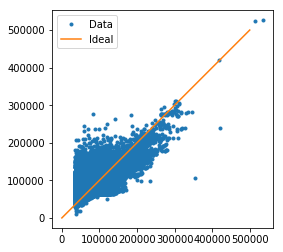

In [43]:
plt.plot(y_train, y_train_pred, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Finding observation with worst result

In [44]:
index = (((y_train.values) - y_train_pred)**2).argmax()
index

1654

In [45]:
y_train_pred[index]

105616.0

In [46]:
X_train.iloc[index]

Year                                               2017
Organization Group Code                               2
Department Code                                     MTA
Union Code                                          253
Job Family Code                                    9100
Job Code                                           9163
Overtime Amount                            few overtime
Retirement Amount          more than average retirement
Health/Dental Amount                  few Health/Dental
Other Benefits Amount                few Other Benefits
Name: 43777, dtype: object

### Plotting target of test set and prediction

In [47]:
y_pred = lr.fit(X_train_transformed, y_train).predict(X_test_transformed)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(0, 500000)

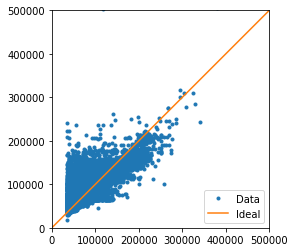

In [48]:
plt.plot(y_test, y_pred, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()
plt.xlim(0,500000)
plt.ylim(0,500000)

## **Decision Tree Regressor**
### Fitting the Model

In [49]:
dt = DecisionTreeRegressor(max_depth=5)

In [50]:
scores = cross_val_score(dt, X_train_transformed, y_train, 
                         scoring='neg_mean_squared_error', cv=10)

In [51]:
show_results(scores)

[21664.9523194  21858.81903351 22620.03928473 22236.68494099
 22493.2642965  22305.59825161 22034.75833712 21880.66895561
 21842.98536561 22001.57076034]
Mean: 22093.934154541017
Std: 293.4664028514571


### Plotting target of train set and prediction

In [52]:
y_train_pred = dt.fit(X_train_transformed, y_train).predict(X_train_transformed)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


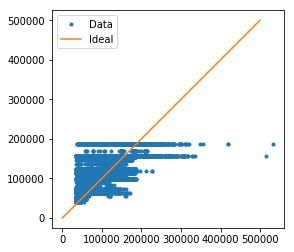

In [53]:
plt.plot(y_train, y_train_pred, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Plotting target of test set and prediction

In [54]:
y_pred = dt.fit(X_train_transformed, y_train).predict(X_test_transformed)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


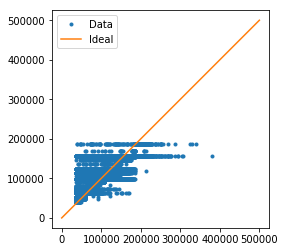

In [55]:
plt.plot(y_test, y_pred, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

## **Random Forest Regressor**
### Fitting the Model

In [56]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1)

In [57]:
t1 = time()

scores = cross_val_score(rf, X_train_transformed, y_train, 
                         scoring='neg_mean_squared_error', cv=10)

print ("Calculation time: {:.2f} [sec]".format(time()-t1))

Calculation time: 991.56 [sec]


In [58]:
show_results(scores)

[18945.06667746 18915.78053665 18957.47245554 19175.07720404
 19232.1196001  19505.22405542 19450.84004066 19055.54001438
 18868.68919211 19251.8654902 ]
Mean: 19135.76752665715
Std: 213.1652031193


### Plotting target of train set and prediction

In [59]:
y_train_pred = rf.fit(X_train_transformed, y_train).predict(X_train_transformed)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


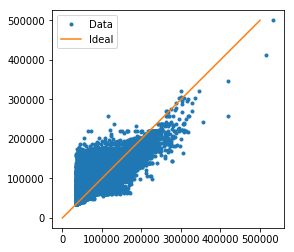

In [60]:
plt.plot(y_train, y_train_pred, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Plotting target of test set and prediction

In [61]:
y_pred = rf.fit(X_train_transformed, y_train).predict(X_test_transformed)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


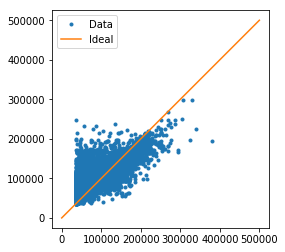

In [62]:
plt.plot(y_test, y_pred, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

# Phase II
# **Prediction and submission with original data**

## Some preprocessing

In [63]:
df3 = df2.copy()

In [64]:
df3.isnull().sum()

Year Type                   0
Year                        0
Organization Group Code     0
Organization Group          0
Department Code             0
Department                  0
Union Code                 27
Union                      27
Job Family Code            32
Job Family                 32
Job Code                    0
Job                         0
Employee Identifier         0
Salaries                    0
Overtime                    0
Other Salaries              0
Total Salary                0
Retirement                  0
Health/Dental               0
Other Benefits              0
Total Benefits              0
Total Compensation          0
Overtime Amount             0
Retirement Amount           0
Health/Dental Amount        0
Other Benefits Amount       0
dtype: int64

In [65]:
# Filling the nulls
df3['Union Code'] = df3['Union Code'].fillna(0)
df3[['Union', 'Job Family Code', 'Job Family']] = df3[['Union', 'Job Family Code', 'Job Family']].fillna('No Value')
df3.isnull().sum()

Year Type                  0
Year                       0
Organization Group Code    0
Organization Group         0
Department Code            0
Department                 0
Union Code                 0
Union                      0
Job Family Code            0
Job Family                 0
Job Code                   0
Job                        0
Employee Identifier        0
Salaries                   0
Overtime                   0
Other Salaries             0
Total Salary               0
Retirement                 0
Health/Dental              0
Other Benefits             0
Total Benefits             0
Total Compensation         0
Overtime Amount            0
Retirement Amount          0
Health/Dental Amount       0
Other Benefits Amount      0
dtype: int64

In [66]:
#Get dummies
df3 = pd.get_dummies(df3, columns=['Year', 'Organization Group Code', 'Department Code', 'Union Code', 'Job Family Code', 'Job Code'])

In [67]:
df3.head()

,Year Type,Organization Group,Department,Union,Job Family,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation,Overtime Amount,Retirement Amount,Health/Dental Amount,Other Benefits Amount,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Organization Group Code_1,Organization Group Code_2,Organization Group Code_3,Organization Group Code_4,Organization Group Code_5,Organization Group Code_6,Organization Group Code_7,Department Code_AAM,Department Code_ADM,Department Code_ADP,Department Code_AIR,Department Code_ART,Department Code_ASR,Department Code_BOS,Department Code_CAT,...,Job Code_H006,Job Code_H008,Job Code_H010,Job Code_H020,Job Code_H022,Job Code_H030,Job Code_H032,Job Code_H033,Job Code_H040,Job Code_H050,Job Code_H051,Job Code_H053,Job Code_H110,Job Code_H120,Job Code_O030,Job Code_O035,Job Code_O535,Job Code_O590,Job Code_O615,Job Code_O695,Job Code_O775,Job Code_O840,Job Code_O865,Job Code_O890,Job Code_O970,Job Code_O990,Job Code_P103,Job Code_Q002,Job Code_Q003,Job Code_Q004,Job Code_Q035,Job Code_Q036,Job Code_Q037,Job Code_Q050,Job Code_Q051,Job Code_Q052,Job Code_Q060,Job Code_Q061,Job Code_Q062,Job Code_Q082
0,Fiscal,Public Protection,FIR Fire Department,"Firefighters - Miscellaneous, Local 798",Fire Services,EMT/Paramedic/Firefighter,37216,123841.28,76853.77,14922.05,215617.10,24574.98,14920.13,3589.87,43084.98,258702.08,less than average overtime,average retirement,less than average Health/Dental,few Other Benefits,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fiscal,"Public Works, Transportation & Commerce",MTA Municipal Transprtn Agncy,"Laborers, Local 261",Semi-Skilled & General Labor,General Laborer,24950,61137.60,7341.04,9218.74,77697.38,14897.71,12516.70,6117.99,33532.40,111229.78,few overtime,more than average retirement,average Health/Dental,less than average Other Benefits,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fiscal,"Public Works, Transportation & Commerce",AIR Airport Commission,"SEIU - Miscellaneous, Local 1021","Clerical, Secretarial & Steno",Senior Clerk,27447,41192.82,0.00,390.00,41582.82,6996.41,11308.96,3200.69,21506.06,63088.88,few overtime,average retirement,more than average Health/Dental,less than average Other Benefits,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fiscal,"Public Works, Transportation & Commerce",MTA Municipal Transprtn Agncy,"Transport Workers - Transit Operators, Local 2...",Street Transit,Transit Operator,42001,66993.68,26633.83,4494.98,98122.49,21231.91,13417.45,7449.63,42098.99,140221.48,less than average overtime,more than average retirement,average Health/Dental,less than average Other Benefits,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fiscal,"Public Works, Transportation & Commerce",DPW GSA - Public Works,"Prof & Tech Engineers - Miscellaneous, Local 21",Professional Engineering,Junior Engineer,22142,74260.80,0.00,0.00,74260.80,13522.95,11989.39,5977.19,31489.53,105750.33,few overtime,average retirement,average Health/Dental,less than average Other Benefits,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Split features and targets from the data**

In [68]:
X_og = df3.drop(['Year Type', 'Organization Group', 'Department', 'Union', 'Job Family', 'Job', 'Employee Identifier', 'Salaries', 'Total Salary',
                 'Total Benefits', 'Total Compensation', 'Overtime Amount', 'Retirement Amount', 'Health/Dental Amount', 'Other Benefits Amount'
                ], axis = 1)
y_og = df3.Salaries
print(X_og.shape,
      y_og.shape)

(147970, 1310) (147970,)


In [69]:
X_og.head()

,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Organization Group Code_1,Organization Group Code_2,Organization Group Code_3,Organization Group Code_4,Organization Group Code_5,Organization Group Code_6,Organization Group Code_7,Department Code_AAM,Department Code_ADM,Department Code_ADP,Department Code_AIR,Department Code_ART,Department Code_ASR,Department Code_BOS,Department Code_CAT,Department Code_CFC,Department Code_CHF,Department Code_CII,Department Code_CLP,Department Code_CON,Department Code_CPC,Department Code_CRT,Department Code_CSC,Department Code_CSS,Department Code_CWP,Department Code_DAT,Department Code_DBI,Department Code_DPH,Department Code_DPW,Department Code_DSS,...,Job Code_H006,Job Code_H008,Job Code_H010,Job Code_H020,Job Code_H022,Job Code_H030,Job Code_H032,Job Code_H033,Job Code_H040,Job Code_H050,Job Code_H051,Job Code_H053,Job Code_H110,Job Code_H120,Job Code_O030,Job Code_O035,Job Code_O535,Job Code_O590,Job Code_O615,Job Code_O695,Job Code_O775,Job Code_O840,Job Code_O865,Job Code_O890,Job Code_O970,Job Code_O990,Job Code_P103,Job Code_Q002,Job Code_Q003,Job Code_Q004,Job Code_Q035,Job Code_Q036,Job Code_Q037,Job Code_Q050,Job Code_Q051,Job Code_Q052,Job Code_Q060,Job Code_Q061,Job Code_Q062,Job Code_Q082
0,76853.77,14922.05,24574.98,14920.13,3589.87,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7341.04,9218.74,14897.71,12516.70,6117.99,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.00,390.00,6996.41,11308.96,3200.69,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,26633.83,4494.98,21231.91,13417.45,7449.63,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.00,0.00,13522.95,11989.39,5977.19,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
X_train_og, X_test_og, y_train_og, y_test_og = split(X_og, y_og)
print(X_train_og.shape, y_train_og.shape)
print(X_test_og.shape, y_test_og.shape)

(110977, 1310) (110977,)
(36993, 1310) (36993,)


## **Linear Regression**

In [71]:
scores = cross_val_score(lr, X_train_og, y_train_og, 
                         scoring='neg_mean_squared_error', cv=10)

In [72]:
show_results(scores)

[7528.77064939 7619.57892124 7812.40032604 7669.31314428 7905.59939098
 7574.45772462 7652.55145169 8015.80737276 7570.64559917 7598.31590262]
Mean: 7694.74404827842
Std: 153.6802385214628


### Train set

In [73]:
y_train_pred_og = lr.fit(X_train_og, y_train_og).predict(X_train_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


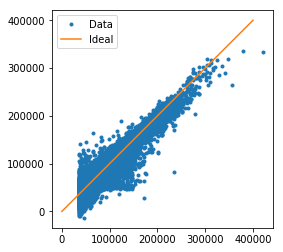

In [74]:
plt.plot(y_train_og, y_train_pred_og, '.', label='Data')
plt.plot([0, 400000], [0, 400000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Test set

In [75]:
y_pred_og = lr.fit(X_train_og, y_train_og).predict(X_test_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


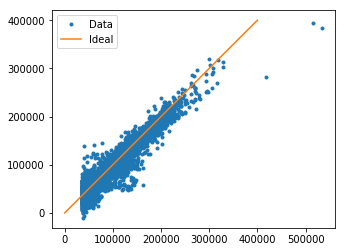

In [76]:
plt.plot(y_test_og, y_pred_og, '.', label='Data')
plt.plot([0, 400000], [0, 400000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

## **Decision Tree Regressor**

In [77]:
dt = DecisionTreeRegressor(max_depth=10)

In [78]:
t1 = time()

scores = cross_val_score(dt, X_train_og, y_train_og, 
                         scoring='neg_mean_squared_error', cv=10)

print ("Calculation time: {:.2f} [sec]".format(time()-t1))

Calculation time: 96.17 [sec]


In [79]:
show_results(scores)

[5578.64650355 5701.09388317 5611.16661629 5417.98008365 5667.11390853
 5727.77206576 5517.87856563 5748.34934084 5318.19152647 5550.71776591]
Mean: 5583.8910259791855
Std: 131.43937257044192


### Train set

In [80]:
y_train_pred_og = dt.fit(X_train_og, y_train_og).predict(X_train_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


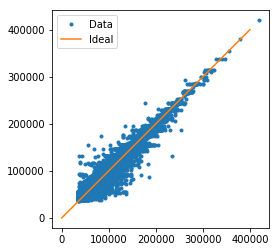

In [81]:
plt.plot(y_train_og, y_train_pred_og, '.', label='Data')
plt.plot([0, 400000], [0, 400000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Test set

In [82]:
y_pred_og = dt.fit(X_train_og, y_train_og).predict(X_test_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


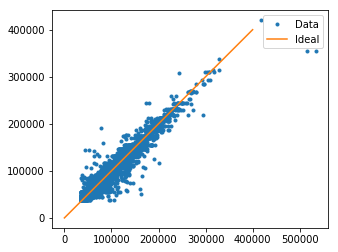

In [83]:
plt.plot(y_test_og, y_pred_og, '.', label='Data')
plt.plot([0, 400000], [0, 400000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

## Random Forest Regressor

In [84]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1)

In [85]:
t1 = time()

scores = cross_val_score(rf, X_train_og, y_train_og, 
                         scoring='neg_mean_squared_error', cv=10)

print ("Calculation time: {:.2f} [sec]".format(time()-t1))

Calculation time: 322.13 [sec]


In [86]:
show_results(scores)

[3637.00533279 3887.47842205 3694.75285602 3600.891201   3890.76674412
 3912.35279196 3652.17177041 4021.47466845 3521.28759037 3898.00444002]
Mean: 3771.618581718558
Std: 159.98043801001717


### Train set

In [87]:
y_train_pred_og = rf.fit(X_train_og, y_train_og).predict(X_train_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


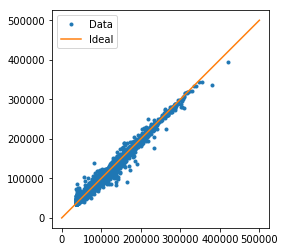

In [88]:
plt.plot(y_train_og, y_train_pred_og, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Test set

In [89]:
y_pred_og = rf.fit(X_train_og, y_train_og).predict(X_test_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


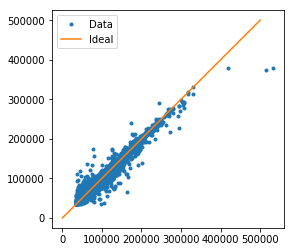

In [90]:
plt.plot(y_test_og, y_pred_og, '.', label='Data')
plt.plot([0, 500000], [0, 500000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()

### Finding best max_depth for DT model

In [91]:
#def show_results_scores(scores):
#    scores_ = (-scores)**0.5
#    return scores_.mean()
#
#t1 = time()
#
#max_depths = np.linspace(1, 25, 25, endpoint=True)
#train_results = []
#for max_depth in max_depths:
#    dt = DecisionTreeRegressor(max_depth=max_depth)
#    # Add score to previous train results
#    scores = cross_val_score(dt, X_train_og, y_train_og, scoring='neg_mean_squared_error', cv=10)
#    train_results.append(show_results_scores(scores))
#print ("Calculation time: {:.2f} [sec]".format(time()-t1))
#    
#from matplotlib.legend_handler import HandlerLine2D
#line1, = plt.plot(max_depths, train_results, 'b', label="Train Score")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#plt.ylabel('Score')
#plt.xlabel('Tree depth')
#plt.show()

In [92]:
#t1 = time()
#
#min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
#train_results = []
#for min_samples_split in min_samples_splits:
#    dt = DecisionTreeRegressor(min_samples_split=min_samples_split)
#    # Add score to previous train results
#    scores = cross_val_score(dt, X_train_og, y_train_og, scoring='neg_mean_squared_error', cv=10)
#    train_results.append(show_results_scores(scores))
#print ("Calculation time: {:.2f} [sec]".format(time()-t1))
#
#from matplotlib.legend_handler import HandlerLine2D
#line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train Score")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#plt.ylabel('Score')
#plt.xlabel('min samples split')
#plt.show()

### DT model - Grid Search

In [93]:
#t1 = time()
#dt_gs = GridSearchCV(dt, 
#                      param_grid={'max_depth': range(1, 21),
#                                  'min_samples_split': range(5, 31),                                  
#                                  'min_samples_leaf': range(5, 31)},
#                      cv=10)
#dt_gs.fit(X_train_og, y_train_og)
#print ("Calculation time: {:.2f} [sec]".format(time()-t1))
#print ("Best parameters:", dt_gs.best_params_)

# Clustering

In [94]:
gmm = GaussianMixture(n_components=4)

In [95]:
clust = np.array(df[['Retirement', 'Health/Dental']])

In [96]:
clust.shape

(213202, 2)

In [97]:
gmm.fit(clust)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [98]:
gmm.means_
gmm.covariances_
#gmm.predict(X)

array([[[ 1.09833957e+08,  1.80298816e+07],
        [ 1.80298816e+07,  1.16407893e+07]],

       [[ 1.85768107e+07,  1.59106886e+07],
        [ 1.59106886e+07,  1.60533298e+07]],

       [[ 1.00000000e-06,  1.69123030e-17],
        [ 1.69123030e-17,  5.01211593e+06]],

       [[ 2.78352056e+07, -1.65801303e+05],
        [-1.65801303e+05,  3.20121411e+05]]])

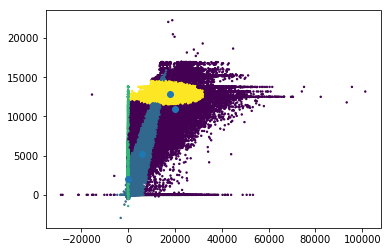

In [99]:
plt.scatter(clust[:,0], clust[:,1], s=2, c= gmm.predict(clust))
plt.scatter(gmm.means_[:, 0], gmm.means_[:,1])
plt.show()

In [100]:
gmm = GaussianMixture(n_components=8)

In [101]:
gmm.fit(clust)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

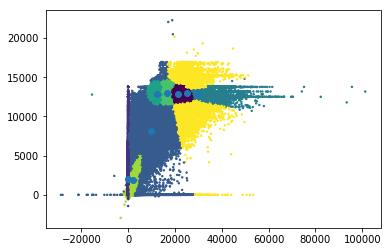

In [102]:
plt.scatter(clust[:,0], clust[:,1], s=2, c= gmm.predict(clust))
plt.scatter(gmm.means_[:, 0], gmm.means_[:,1])
plt.show()

In [103]:
clust_compensation = np.array(X_og[['Overtime', 'Other Salaries', 'Retirement', 'Health/Dental', 'Other Benefits']])

In [104]:
gmm = GaussianMixture(n_components=4)

In [105]:
clust_compensation_minmax = MinMaxScaler().fit_transform(clust_compensation)
#pd.DataFrame(clust_compensation_minmax)

In [106]:
gmm.fit(clust_compensation_minmax)
#gmm.predict(clust_compensation)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [107]:
X_og['Clust Compensation'] = gmm.predict(clust_compensation_minmax)

In [108]:
X_og = pd.get_dummies(X_og, columns=['Clust Compensation'])

In [109]:
X_og.head()

,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Organization Group Code_1,Organization Group Code_2,Organization Group Code_3,Organization Group Code_4,Organization Group Code_5,Organization Group Code_6,Organization Group Code_7,Department Code_AAM,Department Code_ADM,Department Code_ADP,Department Code_AIR,Department Code_ART,Department Code_ASR,Department Code_BOS,Department Code_CAT,Department Code_CFC,Department Code_CHF,Department Code_CII,Department Code_CLP,Department Code_CON,Department Code_CPC,Department Code_CRT,Department Code_CSC,Department Code_CSS,Department Code_CWP,Department Code_DAT,Department Code_DBI,Department Code_DPH,Department Code_DPW,Department Code_DSS,...,Job Code_H022,Job Code_H030,Job Code_H032,Job Code_H033,Job Code_H040,Job Code_H050,Job Code_H051,Job Code_H053,Job Code_H110,Job Code_H120,Job Code_O030,Job Code_O035,Job Code_O535,Job Code_O590,Job Code_O615,Job Code_O695,Job Code_O775,Job Code_O840,Job Code_O865,Job Code_O890,Job Code_O970,Job Code_O990,Job Code_P103,Job Code_Q002,Job Code_Q003,Job Code_Q004,Job Code_Q035,Job Code_Q036,Job Code_Q037,Job Code_Q050,Job Code_Q051,Job Code_Q052,Job Code_Q060,Job Code_Q061,Job Code_Q062,Job Code_Q082,Clust Compensation_0,Clust Compensation_1,Clust Compensation_2,Clust Compensation_3
0,76853.77,14922.05,24574.98,14920.13,3589.87,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,7341.04,9218.74,14897.71,12516.70,6117.99,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.00,390.00,6996.41,11308.96,3200.69,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,26633.83,4494.98,21231.91,13417.45,7449.63,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.00,0.00,13522.95,11989.39,5977.19,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [110]:
X_train_og, X_test_og, y_train_og, y_test_og = split(X_og, y_og)
print(X_train_og.shape, y_train_og.shape)
print(X_test_og.shape, y_test_og.shape)

(110977, 1314) (110977,)
(36993, 1314) (36993,)


In [111]:
scores = cross_val_score(lr, X_train_og, y_train_og, 
                         scoring='neg_mean_squared_error', cv=10)

show_results(scores)

[7645.50647177 7533.31285808 7737.28790243 7670.44394639 7826.26886779
 7671.67460467 7883.85720908 7541.15221855 7732.95128022 7774.77558735]
Mean: 7701.723094630628
Std: 107.44665031958867


In [112]:
y_train_pred_og = lr.fit(X_train_og, y_train_og).predict(X_train_og)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


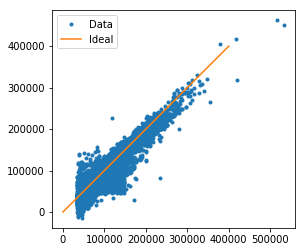

In [113]:
plt.plot(y_train_og, y_train_pred_og, '.', label='Data')
plt.plot([0, 400000], [0, 400000], label='Ideal')
plt.axes().set_aspect('equal')
plt.legend()